In [1]:
import os
import torchvision.models as models 
import torch.nn as nn
import pandas as pd
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import torchvision
from glob import glob
from torchinfo import summary
import numpy as np
import torch.functional as F
import torchvision.transforms as T
from tqdm.notebook import tqdm
import torchmetrics
device0 = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
Type_class='Type_All'
batch_size=256

dataload

In [2]:
#fit
class CustomDataset(Dataset):
    def __init__(self, data,label ,transform=None, target_transform=None):
        self.PPG_data=data
        self.PPG_label=label
    def __len__(self):
        return len(self.PPG_data)

    def __getitem__(self, idx):
        signal_tensor=self.PPG_data[idx]
        AF_signal_label=self.PPG_label[idx]
        return signal_tensor,AF_signal_label
    
train_csv_path ='../../data/AF/Waveform_30/train/'
test_csv_path ='../../data/AF/Waveform_30/test/'

train_data_list=glob(train_csv_path+Type_class+'/**/*.csv')
test_data_list=glob(test_csv_path+Type_class+'/**/*.csv')
train_data=torch.empty(len(train_data_list),1,3000)
train_label=torch.empty(len(train_data_list),1)
test_data=torch.empty(len(test_data_list),1,3000)
test_label=torch.empty(len(test_data_list),1)
for i in range(len(train_data_list)):
    signal_csv=pd.read_csv(train_data_list[i])['PPG'].to_numpy()
    train_data_list[i].find('positive')
    AF_signal_label=0
    if train_data_list[i].find('positive')!=-1:
        AF_signal_label=1
    else:
        AF_signal_label=0
    train_data[i]=torch.tensor(signal_csv)
    train_label[i]=torch.tensor([AF_signal_label])
    
for i in range(len(test_data_list)):
    signal_csv=pd.read_csv(test_data_list[i])['PPG'].to_numpy()
    test_data_list[i].find('positive')
    AF_signal_label=0
    if test_data_list[i].find('positive')!=-1:
        AF_signal_label=1
    else:
        AF_signal_label=0
    test_data[i]=torch.tensor(signal_csv)
    test_label[i]=torch.tensor([AF_signal_label])

train_dataset=CustomDataset(train_data,train_label)
test_dataset=CustomDataset(test_data ,test_label)
dataset_size = len(test_dataset)
test_size = int(dataset_size * 0.5)
validation_size = dataset_size-test_size
validation_dataset, test_dataset = random_split(test_dataset, [validation_size, test_size])
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

model

In [7]:
class CNN1D(nn.Module):
    def __init__(self):
        super(CNN1D,self).__init__()
        self.conv1=nn.Conv1d(in_channels=1, out_channels=50, kernel_size=3,padding='same', padding_mode='replicate')
        self.relu=nn.ReLU()
        self.dropout=nn.Dropout1d(0.5)
        self.pool1=torch.nn.MaxPool1d(kernel_size=5)
        self.conv2=nn.Conv1d(in_channels=50, out_channels=50, kernel_size=3,padding='same', padding_mode='replicate')
        self.relu2=nn.ReLU()
        self.dropout2=nn.Dropout1d(0.5)
        self.pool2=torch.nn.MaxPool1d(kernel_size=5)
        self.fc1=nn.Linear(50*120, 200, bias=False)
        self.fc2=nn.Linear(200, 1, bias=False)
    def forward(self,x):
        
        x=self.conv1(x)
        x=self.relu(x)
        x=self.dropout(x)
        x=self.pool1(x)
        x=self.conv2(x)
        x=self.relu2(x)
        x=self.dropout2(x)
        x=self.pool2(x)
        x = torch.flatten(x, 1)
        x=self.fc1(x)
        x=self.fc2(x)
        return x


    
accuracy = torchmetrics.Accuracy(task="binary", num_classes=1).to(device0)
model = CNN1D().to(device0)
criterion = nn.BCEWithLogitsLoss().to(device0)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
summary(model,(batch_size,1,3000))

Layer (type:depth-idx)                   Output Shape              Param #
CNN1D                                    [256, 1]                  --
├─Conv1d: 1-1                            [256, 50, 3000]           200
├─ReLU: 1-2                              [256, 50, 3000]           --
├─Dropout1d: 1-3                         [256, 50, 3000]           --
├─MaxPool1d: 1-4                         [256, 50, 600]            --
├─Conv1d: 1-5                            [256, 50, 600]            7,550
├─ReLU: 1-6                              [256, 50, 600]            --
├─Dropout1d: 1-7                         [256, 50, 600]            --
├─MaxPool1d: 1-8                         [256, 50, 120]            --
├─Linear: 1-9                            [256, 200]                1,200,000
├─Linear: 1-10                           [256, 1]                  200
Total params: 1,207,950
Trainable params: 1,207,950
Non-trainable params: 0
Total mult-adds (G): 1.62
Input size (MB): 3.07
Forward/backward pa

Train

epoch: 1/1000 train_loss : 0.6975 train_accuracy: 0.5200 val_loss : 0.7006  val_accuracy: 0.4332
epoch: 2/1000 train_loss : 0.6930 train_accuracy: 0.5194 val_loss : 0.6989  val_accuracy: 0.4719


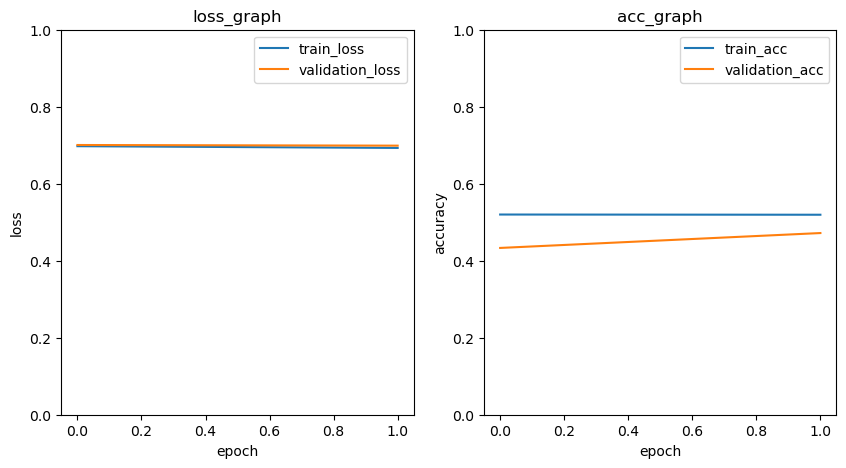

epoch: 3/1000 train_loss : 0.6841 train_accuracy: 0.5485 val_loss : 0.6738  val_accuracy: 0.5461
epoch: 4/1000 train_loss : 0.6738 train_accuracy: 0.5691 val_loss : 0.6712  val_accuracy: 0.5523
epoch: 5/1000 train_loss : 0.6630 train_accuracy: 0.5835 val_loss : 0.6553  val_accuracy: 0.5844
epoch: 6/1000 train_loss : 0.6577 train_accuracy: 0.5918 val_loss : 0.6486  val_accuracy: 0.5816
epoch: 7/1000 train_loss : 0.6487 train_accuracy: 0.6068 val_loss : 0.6454  val_accuracy: 0.5828
epoch: 8/1000 train_loss : 0.6453 train_accuracy: 0.6148 val_loss : 0.6379  val_accuracy: 0.5934
epoch: 9/1000 train_loss : 0.6414 train_accuracy: 0.6188 val_loss : 0.6304  val_accuracy: 0.6090
epoch: 10/1000 train_loss : 0.6325 train_accuracy: 0.6288 val_loss : 0.6264  val_accuracy: 0.6082
epoch: 11/1000 train_loss : 0.6335 train_accuracy: 0.6303 val_loss : 0.6303  val_accuracy: 0.5902
epoch: 12/1000 train_loss : 0.6286 train_accuracy: 0.6382 val_loss : 0.6271  val_accuracy: 0.5883
epoch: 13/1000 train_loss :

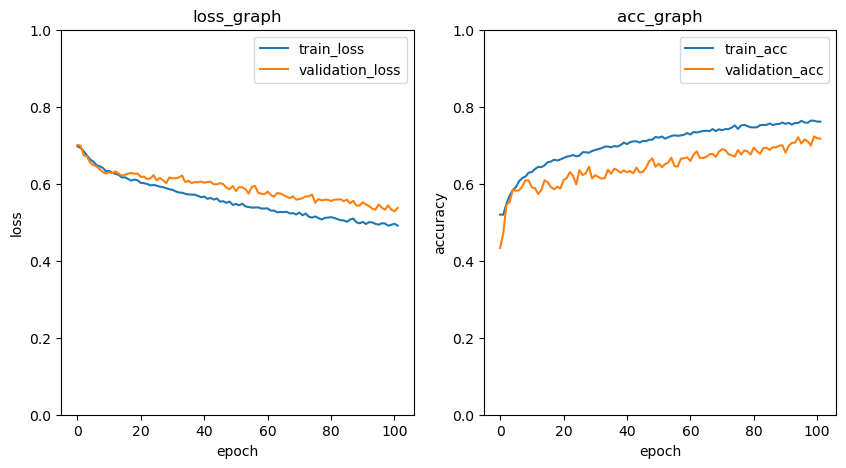

epoch: 103/1000 train_loss : 0.4874 train_accuracy: 0.7636 val_loss : 0.5298  val_accuracy: 0.7277
epoch: 104/1000 train_loss : 0.4905 train_accuracy: 0.7610 val_loss : 0.5255  val_accuracy: 0.7246
epoch: 105/1000 train_loss : 0.4886 train_accuracy: 0.7635 val_loss : 0.5341  val_accuracy: 0.7234
epoch: 106/1000 train_loss : 0.4889 train_accuracy: 0.7651 val_loss : 0.5437  val_accuracy: 0.7059
epoch: 107/1000 train_loss : 0.4862 train_accuracy: 0.7651 val_loss : 0.5196  val_accuracy: 0.7238
epoch: 108/1000 train_loss : 0.4867 train_accuracy: 0.7641 val_loss : 0.5212  val_accuracy: 0.7309
epoch: 109/1000 train_loss : 0.4878 train_accuracy: 0.7649 val_loss : 0.5173  val_accuracy: 0.7316
epoch: 110/1000 train_loss : 0.4855 train_accuracy: 0.7688 val_loss : 0.5288  val_accuracy: 0.7191
epoch: 111/1000 train_loss : 0.4865 train_accuracy: 0.7657 val_loss : 0.5453  val_accuracy: 0.6902
epoch: 112/1000 train_loss : 0.4853 train_accuracy: 0.7685 val_loss : 0.5293  val_accuracy: 0.7238
epoch: 113

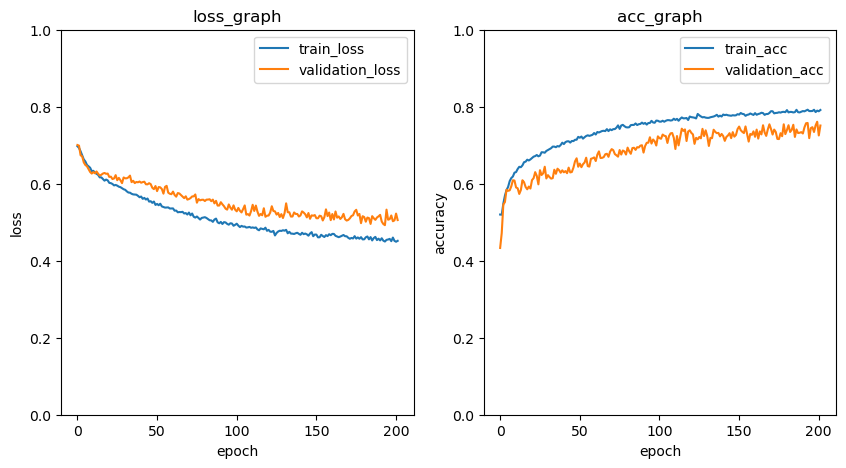

epoch: 203/1000 train_loss : 0.4445 train_accuracy: 0.7959 val_loss : 0.5091  val_accuracy: 0.7465
epoch: 204/1000 train_loss : 0.4539 train_accuracy: 0.7927 val_loss : 0.5135  val_accuracy: 0.7410
epoch: 205/1000 train_loss : 0.4481 train_accuracy: 0.7912 val_loss : 0.4930  val_accuracy: 0.7594
epoch: 206/1000 train_loss : 0.4509 train_accuracy: 0.7897 val_loss : 0.5155  val_accuracy: 0.7395
epoch: 207/1000 train_loss : 0.4468 train_accuracy: 0.7936 val_loss : 0.5089  val_accuracy: 0.7449
epoch: 208/1000 train_loss : 0.4489 train_accuracy: 0.7907 val_loss : 0.4815  val_accuracy: 0.7695
epoch: 209/1000 train_loss : 0.4501 train_accuracy: 0.7931 val_loss : 0.5033  val_accuracy: 0.7504
epoch: 210/1000 train_loss : 0.4540 train_accuracy: 0.7902 val_loss : 0.5039  val_accuracy: 0.7559
epoch: 211/1000 train_loss : 0.4501 train_accuracy: 0.7934 val_loss : 0.4966  val_accuracy: 0.7660
epoch: 212/1000 train_loss : 0.4446 train_accuracy: 0.7978 val_loss : 0.4993  val_accuracy: 0.7457
epoch: 213

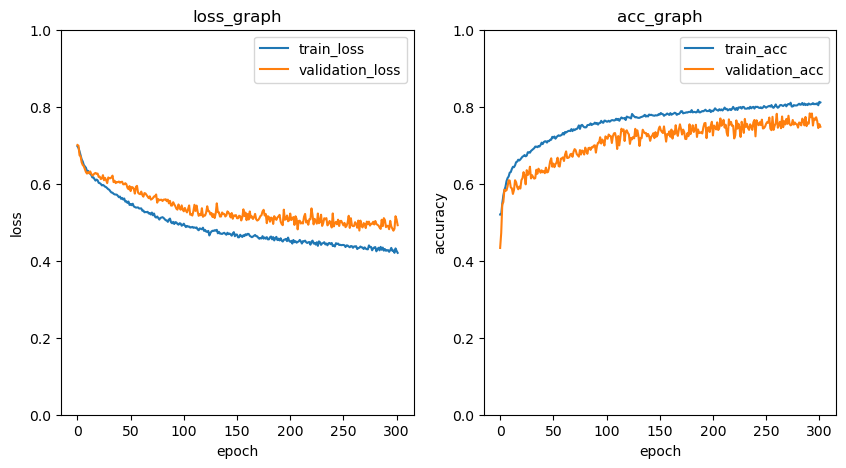

epoch: 303/1000 train_loss : 0.4301 train_accuracy: 0.8085 val_loss : 0.4887  val_accuracy: 0.7629
epoch: 304/1000 train_loss : 0.4348 train_accuracy: 0.8038 val_loss : 0.4908  val_accuracy: 0.7582
epoch: 305/1000 train_loss : 0.4284 train_accuracy: 0.8046 val_loss : 0.4857  val_accuracy: 0.7613
epoch: 306/1000 train_loss : 0.4286 train_accuracy: 0.8082 val_loss : 0.4816  val_accuracy: 0.7719
epoch: 307/1000 train_loss : 0.4258 train_accuracy: 0.8101 val_loss : 0.4806  val_accuracy: 0.7723
epoch: 308/1000 train_loss : 0.4187 train_accuracy: 0.8125 val_loss : 0.4736  val_accuracy: 0.7789
epoch: 309/1000 train_loss : 0.4289 train_accuracy: 0.8110 val_loss : 0.4907  val_accuracy: 0.7629
epoch: 310/1000 train_loss : 0.4317 train_accuracy: 0.8084 val_loss : 0.4916  val_accuracy: 0.7570
epoch: 311/1000 train_loss : 0.4268 train_accuracy: 0.8104 val_loss : 0.4849  val_accuracy: 0.7844
epoch: 312/1000 train_loss : 0.4338 train_accuracy: 0.8056 val_loss : 0.4904  val_accuracy: 0.7703
epoch: 313

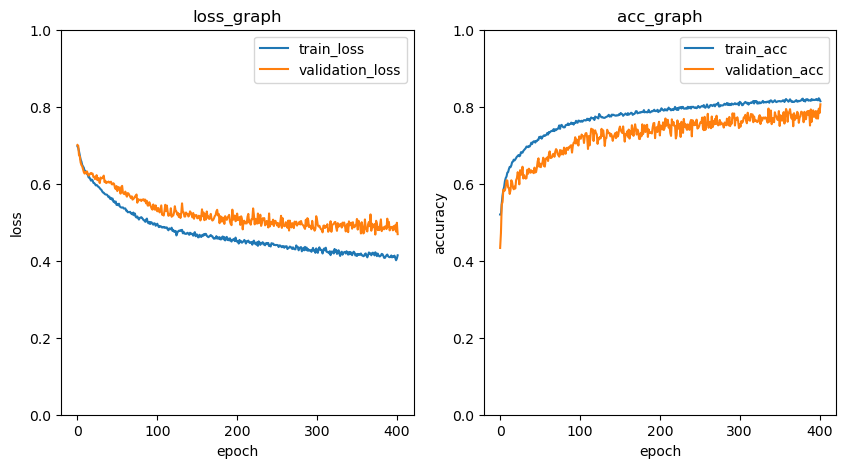

epoch: 403/1000 train_loss : 0.4082 train_accuracy: 0.8214 val_loss : 0.4780  val_accuracy: 0.7762
epoch: 404/1000 train_loss : 0.4032 train_accuracy: 0.8199 val_loss : 0.5136  val_accuracy: 0.7570
epoch: 405/1000 train_loss : 0.4125 train_accuracy: 0.8172 val_loss : 0.4847  val_accuracy: 0.7793
epoch: 406/1000 train_loss : 0.4124 train_accuracy: 0.8214 val_loss : 0.4747  val_accuracy: 0.7859
epoch: 407/1000 train_loss : 0.4101 train_accuracy: 0.8176 val_loss : 0.4848  val_accuracy: 0.7750
epoch: 408/1000 train_loss : 0.4032 train_accuracy: 0.8194 val_loss : 0.4680  val_accuracy: 0.7879
epoch: 409/1000 train_loss : 0.4105 train_accuracy: 0.8198 val_loss : 0.4987  val_accuracy: 0.7746
epoch: 410/1000 train_loss : 0.4067 train_accuracy: 0.8215 val_loss : 0.4851  val_accuracy: 0.7773
epoch: 411/1000 train_loss : 0.4142 train_accuracy: 0.8188 val_loss : 0.5136  val_accuracy: 0.7688
epoch: 412/1000 train_loss : 0.4122 train_accuracy: 0.8179 val_loss : 0.4958  val_accuracy: 0.7727
epoch: 413

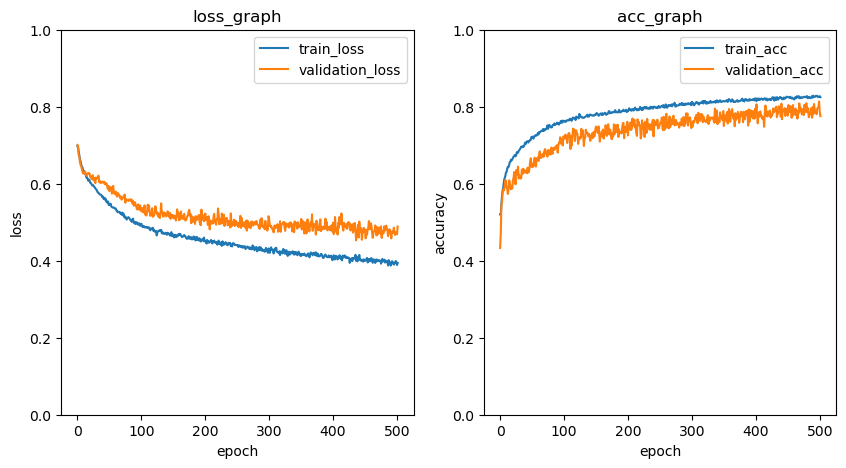

epoch: 503/1000 train_loss : 0.3925 train_accuracy: 0.8274 val_loss : 0.4874  val_accuracy: 0.7867
epoch: 504/1000 train_loss : 0.3876 train_accuracy: 0.8272 val_loss : 0.4874  val_accuracy: 0.7742
epoch: 505/1000 train_loss : 0.3988 train_accuracy: 0.8250 val_loss : 0.4790  val_accuracy: 0.7781
epoch: 506/1000 train_loss : 0.4011 train_accuracy: 0.8229 val_loss : 0.4600  val_accuracy: 0.8156
epoch: 507/1000 train_loss : 0.3943 train_accuracy: 0.8245 val_loss : 0.4869  val_accuracy: 0.7734
epoch: 508/1000 train_loss : 0.3915 train_accuracy: 0.8303 val_loss : 0.4772  val_accuracy: 0.7902
epoch: 509/1000 train_loss : 0.3920 train_accuracy: 0.8288 val_loss : 0.4731  val_accuracy: 0.7887
epoch: 510/1000 train_loss : 0.4049 train_accuracy: 0.8243 val_loss : 0.4756  val_accuracy: 0.7918
epoch: 511/1000 train_loss : 0.3939 train_accuracy: 0.8269 val_loss : 0.4675  val_accuracy: 0.7973
epoch: 512/1000 train_loss : 0.3940 train_accuracy: 0.8311 val_loss : 0.4648  val_accuracy: 0.7965
epoch: 513

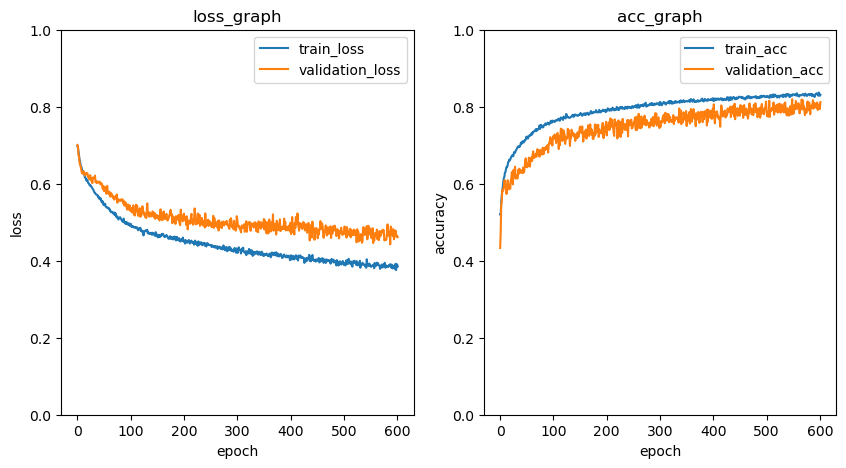

epoch: 603/1000 train_loss : 0.3873 train_accuracy: 0.8290 val_loss : 0.4705  val_accuracy: 0.8070
epoch: 604/1000 train_loss : 0.3833 train_accuracy: 0.8298 val_loss : 0.4592  val_accuracy: 0.8063
epoch: 605/1000 train_loss : 0.3840 train_accuracy: 0.8314 val_loss : 0.4742  val_accuracy: 0.8121
epoch: 606/1000 train_loss : 0.3819 train_accuracy: 0.8336 val_loss : 0.4594  val_accuracy: 0.8031
epoch: 607/1000 train_loss : 0.3826 train_accuracy: 0.8326 val_loss : 0.4665  val_accuracy: 0.7941
epoch: 608/1000 train_loss : 0.3864 train_accuracy: 0.8339 val_loss : 0.4651  val_accuracy: 0.8105
epoch: 609/1000 train_loss : 0.3833 train_accuracy: 0.8333 val_loss : 0.4694  val_accuracy: 0.8082
epoch: 610/1000 train_loss : 0.3867 train_accuracy: 0.8337 val_loss : 0.4656  val_accuracy: 0.8035
epoch: 611/1000 train_loss : 0.3865 train_accuracy: 0.8334 val_loss : 0.4602  val_accuracy: 0.7984
epoch: 612/1000 train_loss : 0.3843 train_accuracy: 0.8340 val_loss : 0.4443  val_accuracy: 0.8180
epoch: 613

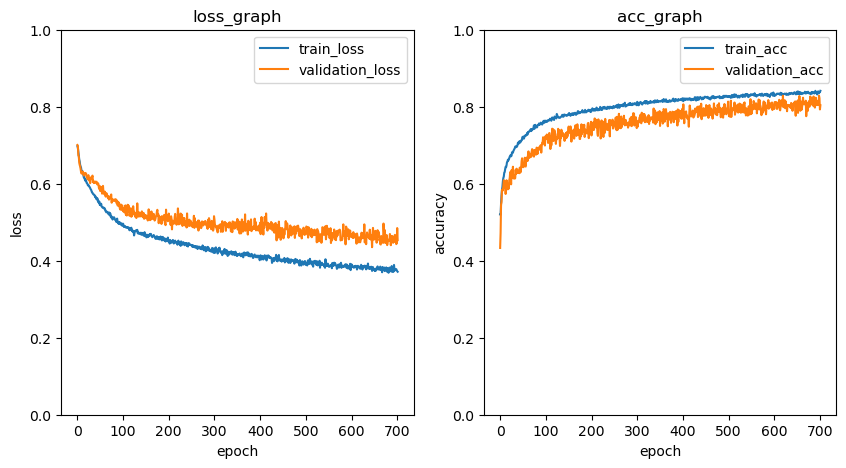

epoch: 703/1000 train_loss : 0.3763 train_accuracy: 0.8356 val_loss : 0.4538  val_accuracy: 0.8145
epoch: 704/1000 train_loss : 0.3717 train_accuracy: 0.8388 val_loss : 0.4696  val_accuracy: 0.8180
epoch: 705/1000 train_loss : 0.3784 train_accuracy: 0.8368 val_loss : 0.4659  val_accuracy: 0.8094
epoch: 706/1000 train_loss : 0.3729 train_accuracy: 0.8424 val_loss : 0.4451  val_accuracy: 0.8289
epoch: 707/1000 train_loss : 0.3779 train_accuracy: 0.8352 val_loss : 0.4727  val_accuracy: 0.7937
epoch: 708/1000 train_loss : 0.3796 train_accuracy: 0.8348 val_loss : 0.4590  val_accuracy: 0.8078
epoch: 709/1000 train_loss : 0.3690 train_accuracy: 0.8374 val_loss : 0.4435  val_accuracy: 0.8160
epoch: 710/1000 train_loss : 0.3726 train_accuracy: 0.8411 val_loss : 0.4719  val_accuracy: 0.8109
epoch: 711/1000 train_loss : 0.3787 train_accuracy: 0.8353 val_loss : 0.4608  val_accuracy: 0.8086
epoch: 712/1000 train_loss : 0.3786 train_accuracy: 0.8377 val_loss : 0.4414  val_accuracy: 0.8207
epoch: 713

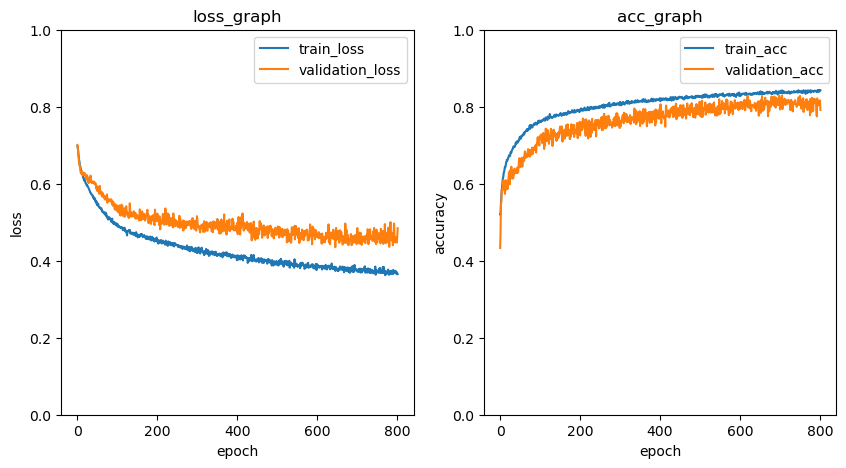

epoch: 803/1000 train_loss : 0.3758 train_accuracy: 0.8372 val_loss : 0.4561  val_accuracy: 0.8168
epoch: 804/1000 train_loss : 0.3685 train_accuracy: 0.8422 val_loss : 0.4541  val_accuracy: 0.8105
epoch: 805/1000 train_loss : 0.3650 train_accuracy: 0.8437 val_loss : 0.4623  val_accuracy: 0.8023
epoch: 806/1000 train_loss : 0.3671 train_accuracy: 0.8422 val_loss : 0.4743  val_accuracy: 0.8047
epoch: 807/1000 train_loss : 0.3644 train_accuracy: 0.8455 val_loss : 0.4818  val_accuracy: 0.8023
epoch: 808/1000 train_loss : 0.3617 train_accuracy: 0.8429 val_loss : 0.4753  val_accuracy: 0.8102
epoch: 809/1000 train_loss : 0.3768 train_accuracy: 0.8394 val_loss : 0.4546  val_accuracy: 0.8133
epoch: 810/1000 train_loss : 0.3674 train_accuracy: 0.8432 val_loss : 0.4587  val_accuracy: 0.8105
epoch: 811/1000 train_loss : 0.3735 train_accuracy: 0.8414 val_loss : 0.4730  val_accuracy: 0.8035
epoch: 812/1000 train_loss : 0.3678 train_accuracy: 0.8410 val_loss : 0.4819  val_accuracy: 0.7957
epoch: 813

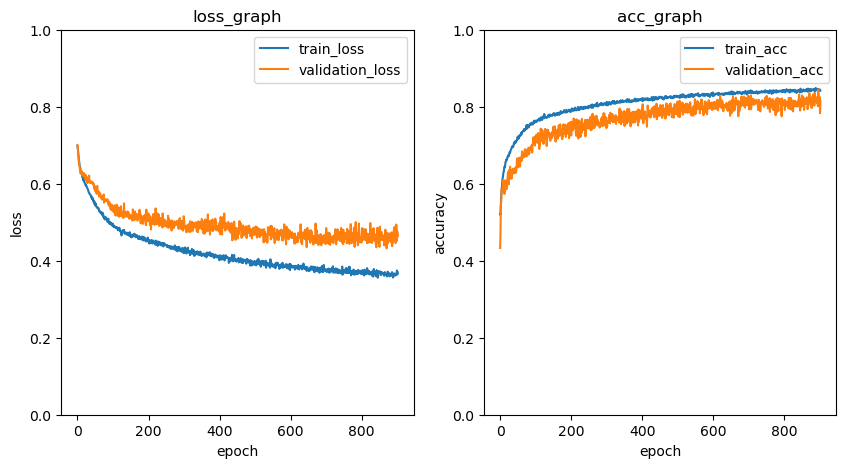

epoch: 903/1000 train_loss : 0.3630 train_accuracy: 0.8403 val_loss : 0.4631  val_accuracy: 0.8133
epoch: 904/1000 train_loss : 0.3636 train_accuracy: 0.8430 val_loss : 0.4702  val_accuracy: 0.8074
epoch: 905/1000 train_loss : 0.3718 train_accuracy: 0.8420 val_loss : 0.4845  val_accuracy: 0.8027
epoch: 906/1000 train_loss : 0.3590 train_accuracy: 0.8454 val_loss : 0.4765  val_accuracy: 0.8086
epoch: 907/1000 train_loss : 0.3666 train_accuracy: 0.8442 val_loss : 0.4992  val_accuracy: 0.8027
epoch: 908/1000 train_loss : 0.3742 train_accuracy: 0.8375 val_loss : 0.4684  val_accuracy: 0.7988
epoch: 909/1000 train_loss : 0.3558 train_accuracy: 0.8475 val_loss : 0.4629  val_accuracy: 0.8262
epoch: 910/1000 train_loss : 0.3671 train_accuracy: 0.8431 val_loss : 0.4544  val_accuracy: 0.8254
epoch: 911/1000 train_loss : 0.3686 train_accuracy: 0.8376 val_loss : 0.4586  val_accuracy: 0.8125
epoch: 912/1000 train_loss : 0.3618 train_accuracy: 0.8456 val_loss : 0.4453  val_accuracy: 0.8246
epoch: 913

In [8]:
MIN_loss=5000
train_loss_list=[]
val_loss_list=[]
train_acc_list=[]
val_acc_list=[]
for epoch in range(1000):
    
    train_count=0
    running_loss = 0.0
    acc_loss=0
    for x, y in train_dataloader:
        model.train()
        y = y.to(device0).float()
        train_count+=1
        x=x.to(device0).float()
        optimizer.zero_grad()  # optimizer zero 로 초기화
        predict = model(x).to(device0)
        cost = criterion(predict, y) # cost 구함
        acc=accuracy(predict, y)
        cost.backward() # cost에 대한 backward 구함
        optimizer.step() 
        running_loss += cost.item()
        acc_loss+=acc
    
    train_loss_list.append((running_loss/train_count))
    train_acc_list.append((acc_loss/train_count).cpu().detach().numpy())
#validation
    model.eval()
    val_count=0
    val_running_loss=0.0
    val_acc_loss=0
    with torch.no_grad():
        for x, y in validation_dataloader:
            y = y.to(device0).float()
            val_count+=1
            x=x.to(device0).float()
            
            predict = model(x).to(device0)
            acc=accuracy(predict, y)
            cost = criterion(predict, y)
            val_running_loss+=cost.item()
            val_acc_loss+=acc
        print(f"\repoch: {epoch+1}/{1000} train_loss : {running_loss/train_count:.4f} train_accuracy: {acc_loss/train_count:.4f} val_loss : {val_running_loss/val_count:.4f}  val_accuracy: {val_acc_loss/val_count:.4f}")
        
        val_loss_list.append((val_running_loss/val_count))
        val_acc_list.append((val_acc_loss/val_count).cpu().detach().numpy())
    if epoch%100==1:
        plt.figure(figsize=(10,5))
        plt.subplot(1, 2, 1) 
        plt.title('loss_graph')
        plt.plot(np.arange(epoch+1),train_loss_list,label='train_loss')
        plt.plot(np.arange(epoch+1),val_loss_list,label='validation_loss')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.ylim([0, 1]) 
        plt.legend()
        plt.subplot(1, 2, 2)  
        plt.title('acc_graph')
        plt.plot(np.arange(epoch+1),train_acc_list,label='train_acc')
        plt.plot(np.arange(epoch+1),val_acc_list,label='validation_acc')
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.ylim([0, 1]) 
        plt.legend()
        plt.show()
        
    if MIN_loss>(val_running_loss/val_count):
        torch.save(model.state_dict(), '../../model/Waveform/'+Type_class+'/BiLSTM_CNN_1D_30_TypeAll_call_back.pt')
        MIN_loss=(val_running_loss/val_count)
torch.save(model.state_dict(), '../../model/Waveform/'+Type_class+'/BiLSTM_CNN_1D_30_TypeAll.pt')

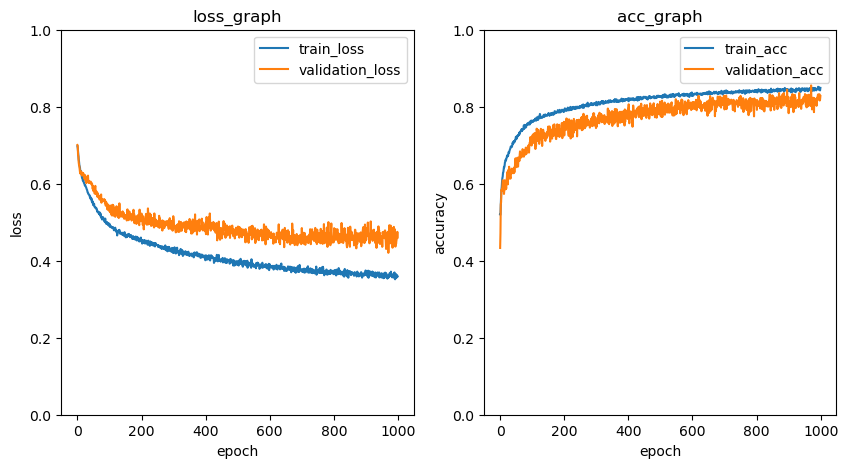

In [9]:
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1) 
plt.title('loss_graph')
plt.plot(np.arange(epoch+1),train_loss_list,label='train_loss')
plt.plot(np.arange(epoch+1),val_loss_list,label='validation_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.ylim([0, 1]) 
plt.legend()
plt.subplot(1, 2, 2)  
plt.title('acc_graph')
plt.plot(np.arange(epoch+1),train_acc_list,label='train_acc')
plt.plot(np.arange(epoch+1),val_acc_list,label='validation_acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim([0, 1]) 
plt.legend()
plt.show()